In [1]:
from unittest.mock import right

from torch.backends.mkl import verbose
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries


## Read data

In [51]:
electricity_consumption = pd.read_csv("../WeatherPreprocessing/WeatherBusinessResidential.csv")
electricity_consumption

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh)
0,2010-01-01,41.90,20.05,17.40,4.20,11.0,1.70,2010.0,1.0,572.918,282.000
1,2010-02-01,34.80,21.35,19.70,3.65,8.0,1.20,2010.0,2.0,564.809,259.792
2,2010-03-01,7.60,19.30,16.65,4.35,12.5,1.45,2010.0,3.0,621.988,295.270
3,2010-04-01,48.40,17.05,16.05,3.15,7.0,1.40,2010.0,4.0,573.259,303.576
4,2010-05-01,197.50,14.60,14.40,3.55,12.5,1.95,2010.0,5.0,608.594,363.480
...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,43.80,20.35,17.85,3.70,3.5,1.30,2024.0,2.0,574.002,311.724
170,2024-03-01,55.65,17.90,15.60,4.10,10.5,2.10,2024.0,3.0,581.184,337.730
171,2024-04-01,81.95,16.95,15.95,3.65,8.0,1.80,2024.0,4.0,555.174,348.859
172,2024-05-01,115.75,13.35,12.80,3.75,11.5,1.75,2024.0,5.0,593.551,452.473


In [52]:
# read immigration data
immigration = pd.read_csv("../immigrationData/immigration_population_type.csv")
immigration['Date'] = pd.to_datetime(immigration['Date'], format='%Y-%m-%d')
immigration['Date'] = immigration['Date'] - pd.offsets.MonthEnd(1) + pd.offsets.Day(1)
electricity_consumption['Date'] = pd.to_datetime(electricity_consumption['Date'], format='%Y-%m-%d')
electricity_consumption = electricity_consumption.merge(immigration, on='Date', how='left')


In [53]:
electricity_consumption

,Date,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh),Count
0,2010-01-01,41.90,20.05,17.40,4.20,11.0,1.70,2010.0,1.0,572.918,282.000,343359
1,2010-02-01,34.80,21.35,19.70,3.65,8.0,1.20,2010.0,2.0,564.809,259.792,359247
2,2010-03-01,7.60,19.30,16.65,4.35,12.5,1.45,2010.0,3.0,621.988,295.270,358956
3,2010-04-01,48.40,17.05,16.05,3.15,7.0,1.40,2010.0,4.0,573.259,303.576,352014
4,2010-05-01,197.50,14.60,14.40,3.55,12.5,1.95,2010.0,5.0,608.594,363.480,342921
...,...,...,...,...,...,...,...,...,...,...,...,...
169,2024-02-01,43.80,20.35,17.85,3.70,3.5,1.30,2024.0,2.0,574.002,311.724,586782
170,2024-03-01,55.65,17.90,15.60,4.10,10.5,2.10,2024.0,3.0,581.184,337.730,595638
171,2024-04-01,81.95,16.95,15.95,3.65,8.0,1.80,2024.0,4.0,555.174,348.859,598620
172,2024-05-01,115.75,13.35,12.80,3.75,11.5,1.75,2024.0,5.0,593.551,452.473,593892


In [54]:
# Convert dataframe to Timeseries
ts = TimeSeries.from_dataframe(electricity_consumption, time_col="Date" )

<Axes: xlabel='Date'>

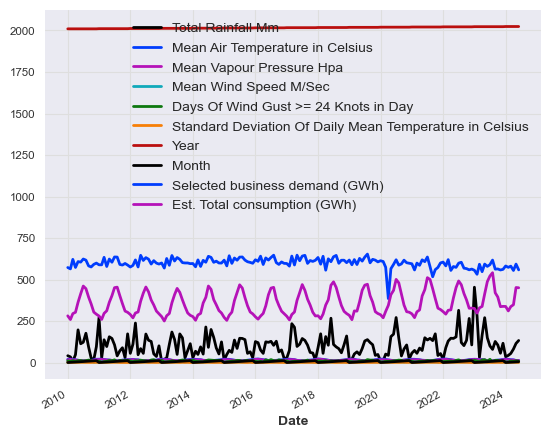

In [4]:
ts.plot()

<Axes: xlabel='Date'>

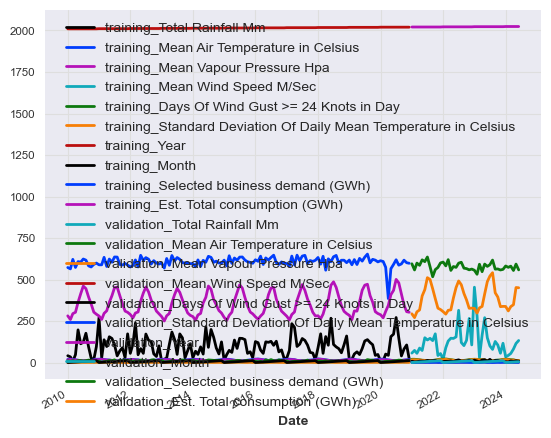

In [58]:
# training and validation split
train, val = ts.split_before(pd.Timestamp('2021-01-01'))
train.plot(label='training')
val.plot(label='validation')

## Preprocessing

In [147]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from sklearn.preprocessing import MinMaxScaler

from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape, mae, rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries

scaler = MinMaxScaler(feature_range=(0, 1))
transformer = Scaler(scaler)
transformer_target = Scaler(scaler)

train_target_og = train['Est. Total consumption (GWh)']
val_target_og = val['Est. Total consumption (GWh)']
train_target = transformer_target.fit_transform(train_target_og)
val_target = transformer_target.transform(val_target_og)

train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(ts)

#split past covariates
train_past_cov = train_transformed[['Days Of Wind Gust >= 24 Knots in Day', 'Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa', 'Count']]
val_past_cov = val_transformed[['Days Of Wind Gust >= 24 Knots in Day', 'Mean Air Temperature in Celsius', 'Mean Vapour Pressure Hpa', 'Count']]

# replace missing value with the mean of column
train_past_cov = train_past_cov.pd_dataframe()
train_past_cov = train_past_cov.apply(lambda col: col.fillna(col.mean()))
train_past_cov = TimeSeries.from_dataframe(train_past_cov)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [108]:
train_transformed.pd_dataframe()

component,Total Rainfall Mm,Mean Air Temperature in Celsius,Mean Vapour Pressure Hpa,Mean Wind Speed M/Sec,Days Of Wind Gust >= 24 Knots in Day,Standard Deviation Of Daily Mean Temperature in Celsius,Year,Month,Selected business demand (GWh),Est. Total consumption (GWh),Count
Date,,,,,,,,,,,
2010-01-01,0.129875,0.797357,0.653061,0.611111,0.545455,0.342105,0.0,0.000000,0.698370,0.123807,0.205978
2010-02-01,0.102991,0.911894,0.887755,0.407407,0.363636,0.078947,0.0,0.090909,0.668095,0.035130,0.289332
2010-03-01,0.000000,0.731278,0.576531,0.666667,0.636364,0.210526,0.0,0.181818,0.881573,0.176794,0.287805
2010-04-01,0.154487,0.533040,0.515306,0.222222,0.303030,0.184211,0.0,0.272727,0.699643,0.209960,0.251385
2010-05-01,0.719046,0.317181,0.346939,0.370370,0.636364,0.473684,0.0,0.363636,0.831567,0.449157,0.203680
...,...,...,...,...,...,...,...,...,...,...,...
2020-08-01,0.534267,0.154185,0.158163,0.500000,0.818182,0.263158,1.0,0.636364,0.751438,0.917249,0.813995
2020-09-01,0.125331,0.220264,0.112245,0.648148,0.727273,0.526316,1.0,0.727273,0.779914,0.648959,0.773687
2020-10-01,0.282469,0.440529,0.357143,0.333333,0.181818,0.763158,1.0,0.818182,0.863608,0.384243,0.738542


## Model training and testing

In [7]:
import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [122]:
model_gru = BlockRNNModel(
    model="GRU",
    n_rnn_layers=3,
    hidden_dim=100,
    n_epochs=100,
    optimizer_kwargs={"lr": 1e-2},
    model_name="Electricity_GRU",
    log_tensorboard=True,
    input_chunk_length=36,
    save_checkpoints=True,
    force_reset = True,
    output_chunk_length=42,
    random_state=20
)

model_gru.fit(train_target,
   past_covariates = train_past_cov,
    verbose=False)

BlockRNNModel(output_chunk_shift=0, model=GRU, hidden_dim=100, n_rnn_layers=3, hidden_fc_sizes=None, dropout=0.0, n_epochs=100, optimizer_kwargs={'lr': 0.01}, model_name=Electricity_GRU, log_tensorboard=True, input_chunk_length=36, save_checkpoints=True, force_reset=True, output_chunk_length=42, random_state=20)

Predicting: |          | 0/? [00:00<?, ?it/s]

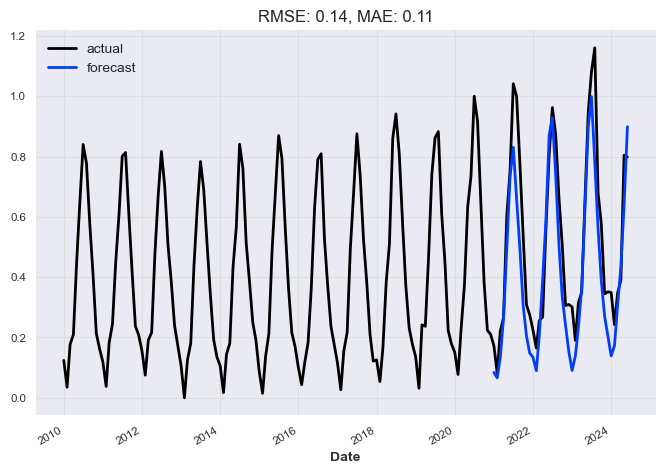

In [123]:
def eval_model(model):
    pred_series = model.predict(n=42)
    plt.figure(figsize=(8, 5))
    series_transformed['Est. Total consumption (GWh)'].plot(label="actual")
    pred_series['Est. Total consumption (GWh)'].plot(label="forecast")
    plt.title("RMSE: {:.2f}, MAE: {:.2f}".format(rmse(val_target, pred_series), mae(val_target, pred_series)))
    plt.legend()
    return pred_series

pred_series_transformed = eval_model(model_gru)

# Mean Absolute Percentage Error

In [156]:
mae(transformer_target.inverse_transform(val_target), transformer_target.inverse_transform(pred_series_transformed))

28.705175229582125

In [154]:
def cal_ape(pred, actual, pred_norm, actual_norm):
    for i in range(len(pred)):
        pred_val = pred[i]
        actual_val = actual[i]
        pred_norm_val = pred_norm[i]
        actual_norm_val = actual_norm[i]
        ape = abs((actual_val - pred_val) / actual_val) * 100
        ape_norm = abs((actual_norm_val - pred_norm_val) / actual_norm_val) * 100
        print(ape, ape_norm)
        pd.concat([ape_df, pd.DataFrame.from_records([{'normalized': ape_norm, 'unnormalized': ape}])])

ape_df = pd.DataFrame(columns=['normalized', 'unnormalized'])

pred = transformer_target.inverse_transform(pred_series_transformed)
actual = transformer_target.inverse_transform(val_target)
cal_ape(pred.pd_series(), actual.pd_series(), pred_series_transformed.pd_series(), val_target.pd_series())
    

7.503524485708008 51.129645050123095
1.3654350815806118 18.29051843711649
7.231142606161223 40.10216329421391
0.09270075147245163 0.44190279882456474
6.729809636813602 17.936589135784537
1.143863892295334 2.6632005654681503
10.309553293566797 20.231318371424152
16.971143824184505 34.004586749564666
15.817590869555886 36.30303685418612
15.063344015818142 43.07182601352352
7.834248387757425 33.308394518561755
9.936367299534309 46.08398265709164
7.320634092115302 40.020447822363636
6.43703342744362 45.53527818430509
3.988986731084941 19.57253385444962
9.728394415089912 46.1792308010258
1.904098166549328 5.353867289484026
3.658933666175898 8.21664836611414
1.735916233630266 3.5435864467721205
7.031633122616457 15.115220537953691
9.403023949603433 23.668548173990157
11.446316681582765 34.07051784688592
4.96766469663434 21.24832060663025
11.799656533573149 50.022295942840344
16.175812496228993 69.92259409112575
4.264722744871572 26.759622831585745
6.2274596942661695 26.03402640447246
1.12379

In [149]:
actual.pd_dataframe()

component,Est. Total consumption (GWh)
Date,
2021-01-01,294.164
2021-02-01,271.243
2021-03-01,306.209
2021-04-01,317.624
2021-05-01,401.719
2021-06-01,439.960
2021-07-01,511.798
2021-08-01,501.070
2021-09-01,444.796


In [ ]:
# check seasonablity
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, m=12, alpha=0.05, max_lag=24)